In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as MVN

plt.rcParams['figure.figsize']=(5,5)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

# Modelos de verosimilitud gaussianos

En este caso asumimos que la **verosimilitud** está modelada en conjunto por una **distribución normal multivariada (MVN)**; es decir una distribución normal pero en $D$ dimensiones.



Los parámetros de una MVN son su centro, que se corresponde con el punto de mayor densidad de probabilidad y con la media; y su _anchura_ que viene determinada por la matriz de covarianza.

En problemas de clasificación binaria, si asumimos que todas las clases son igualmente probables a priori, entonces
$$
y^* = \mathop{\arg\max}\limits_{y} p(y|{\bf x}) = \mathop{\arg\max}\limits_{y} p({\bf x}|y).
$$

Si sustituimos la $p$ por la MVN entonces la etiqueta asignada a un ejemplo  $x$ será

$$
\left\lbrace
\begin{array}{llll}
y^* = 0 & {\rm si} & {\rm MVN}({\bf x}|y=0) > {\rm MVN}({\bf x}|y=1)   \\
y^* = 1 & {\rm si} & {\rm MVN}({\bf x}|y=0) < {\rm MVN}({\bf x}|y=1)   \\
\end{array}
\right.
$$

**IMPORTANTE**

En la celda anterior hemos asumido que las clases son igualmente probables a priori, pero igualmente podríamos haber asumido que existe una probabilidad a priori sobre la clase. <br>
En ese caso, como ya sabemos,
$$
y^* = \mathop{\arg\max}\limits_{y} p(y|{\bf x}) = \mathop{\arg\max}\limits_{y} \big( p(y) \cdot p({\bf x}|y)   \big).
$$

**Recuerta también que:**

Es preferible trabajar con logaritmos para evitar problemas de precisión en los ordenadores. <br>
Por tanto la expresión anterior se reescribe como
$$
y^* = \mathop{\arg\max}\limits_{y} \log p(y|{\bf x}) = \mathop{\arg\max}\limits_{y} \big( \log p(y) + \log p({\bf x}|y)   \big).
$$


## Procedimiento general

1. Aprender los parámetros de cada modelo de verosimilitud a partir de los datos del conjunto de entrenamiento; es decir:
$$
\left\lbrace
\begin{array}{llllllll}
\{\mu_0, {\bf \Sigma}_0\} & {\rm para~~la} & {\rm MVN}({\bf x}|y=0;~ \mu_0, {\bf \Sigma}_0) & \leftarrow \text{modelo de verosimilitud de la clase 0}\\[.3em]
\{\mu_1, {\bf \Sigma}_1\} & {\rm para~~la} & {\rm MVN}({\bf x}|y=1;~ \mu_1, {\bf \Sigma}_1) & \leftarrow \text{modelo de verosimilitud de la clase 1}
\end{array}
\right.
$$
Para ello:
  1. Se separan los ejemplos de entrenamiento de cada clase
  2. Se estima la media y la covarianza de los ejemplos de cada clase

<center>

$\rightarrow~$ Nuestros modelos de verosimilitud gaussiano <b> ya están aprendidos </b> $~\rightarrow~$ ¡ Ya podemos hacer inferencia !

</center>

2. Cuando llegan ejemplos nuevos, sólo hay que evaluarlos en cada modelo de verosimilitud. <br>
<center>

$\rightarrow$ La etiqueta será la que se corresponde con el modelo donde es más probable.

</center>

## Interpretación

Para entender lo que sucede, vamos a visualizarlo con ejenplos de solo 2 dimensiones.

Cada MVN es una _campana_ centrada en su media y con una forma que dependerá de su matriz de covarianza.

Si pintamos _lonchas_ de esas _campanas_ a diferentes alturas, allá donde se crucen serán puntos $\bf x$ donde ${\rm MVN}_0({\bf x}) = {\rm MVN}_1({\bf x})$.
Esos puntos están sobre la superficie de decisión.

Vamos a verlo en un ejemplo con código.

### Ejemplo

#### Carga y procesado de datos

In [ ]:
#--- Funciones auxiliares ---

def get_binary_Y(target_names, target, y):
  class_selected = np.argwhere(target_names==target)[0,0]
  return (y==class_selected)*1

#=== Cargar y separar datos ===
iris = load_iris()
target = 'virginica' #<- 'setosa', 'versicolor', 'virginica'
test_size = 0.1

X = iris.data
y = iris.target
y = get_binary_Y(iris.target_names, target, y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = test_size,
                                                    shuffle=True, stratify = y,
                                                    random_state=seed)

#===  Utilizar StandardScaler, PCA y MaxAbsScaler para dejar solo 2 dimensiones ===
scaler_std = StandardScaler()
scaler_std.fit(X_train)
X_train_std = scaler_std.transform(X_train)
#
n_components = 2
pca = PCA(n_components = n_components)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
#
scaler_max = MaxAbsScaler()
scaler_max.fit(X_train_pca)
X_train_final = scaler_max.transform(X_train_pca)

#### Aprendizaje de los modelos de verosimilitud

In [ ]:
class GaussianLogLikelihoodModel():

  def __init__(self):
    pass

  def fit(self, X, y):
    self.labels = np.unique(y)
    #=== Separar los datos de entrenamiento según su clase ===
    self.X_list = []
    for label in self.labels:
      self.X_list.append( X[y==label] )
    #=== Aprender un modelo de verosimilitud para cada clase ===
    self.mu_list = []
    self.sigma_list = []
    self.model_list = []
    for X_class in self.X_list:
      mu = np.mean(X_class, axis=0)
      sigma = np.cov(X_class, rowvar=False)             #<- atención a las opciones!
      self.mu_list.append(mu)
      self.sigma_list.append(sigma)
      self.model_list.append( MVN(mean=mu, cov=sigma) ) #<- atención a las opciones!
    return

  def predict(self, X):
    y_prob = self.predict_proba(X)
    y_hat  = np.argmax(y_prob, axis=1)
    return y_hat

  def predict_proba(self, X):
    prob_list = []
    for model in self.model_list:
      p = model.logpdf(X)
      prob_list.append(p)
    y_prob = np.array(prob_list).T
    self.logP_min = y_prob.min(axis=0)
    self.logP_max = y_prob.max(axis=0)
    return y_prob

In [ ]:
#=== ENTRENAMIENTO ===

gda = GaussianLogLikelihoodModel()
gda.fit(X_train_final, Y_train)

#### Inferencia

In [ ]:
#=== Crear un conjunto de test que se corresponde con un barrido del intervalo ===
ns = 120
lowBound = X_train_final.min(axis=0)
upBound  = X_train_final.max(axis=0)
range0 = np.linspace(lowBound[0], upBound[0], ns)
range1 = np.linspace(lowBound[1], upBound[1], ns)
mesh0, mesh1 = np.meshgrid(range0, range1)
interval_test = np.concatenate( [mesh0.reshape(ns*ns,1),
                                 mesh1.reshape(ns*ns,1)] ,
                                axis=1 )

#=== Inferir para cada punto del barrido que hemos hecho ===

y_prob = gda.predict_proba(interval_test)
y_hat  = np.argmax(y_prob, axis=1)
y_hat = y_hat.reshape(ns,ns)

#### Visualización

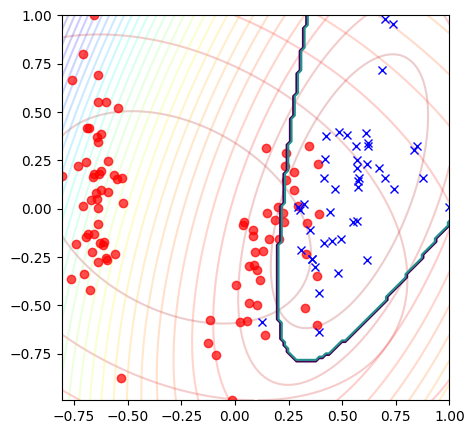

In [ ]:
contour_levels = np.linspace(y_prob.min(), y_prob.max(), 30)

plt.contour(range0, range1, y_prob[:,0].reshape(ns,ns), contour_levels,
            alpha=0.2, cmap='jet')
plt.contour(range0, range1, y_prob[:,1].reshape(ns,ns), contour_levels,
            alpha=0.2, cmap='jet')
plt.plot(gda.X_list[0][:,0], gda.X_list[0][:,1], 'ro' , alpha=0.7)
plt.plot(gda.X_list[1][:,0], gda.X_list[1][:,1], 'bx' , alpha=0.99)
plt.contour(range0, range1, y_hat, 1)
plt.show()

En la figura se puede apreciar que la superficie de decisión paso por los puntos donde las curvas de nivel (técnicamente _curvas de equidensidad_) de la misma altura (es decir de la misma densidad de probabilidad) se cruzan.

# Variantes posibles

El paso más costoso computacionalmente es calcular la matriz de covarianza, ya que calcular la media es rápido y sencillo para un ordenador.

Una manera de simplificar el aprendizaje de los modelos de verosimilitud es evitando calcular la covarianza.

De este modo se pueden dar 3 posibilidades:
- No calculamos la covarianza sino la varianza; es decir dejamos solo la diagonal de la matriz de covarianza.<br>
$~\rightarrow$ Recuperamos el clasificador Naive Bayes (NB) con modelos de verosimilitud gaussianos.
- Asumimos que todas las matrices de covarianza son identicas <br>
$~\rightarrow$ Obtenemos un clasificador LINEAL denominado _Linear Discriminant Analysis_ (LDA).
- No asumimos nada acerca de las matrices de covarianza y calculamos todas<br>
$~\rightarrow$ Obtenemos la expresión de un clasificador NO lineal denominado _Quadratic Discriminant Analysis_ (QDA).

## LDA

Resultado de asumir que todos los modelos de verosimilitud tienen la misma matriz de covarianza.

Si esto ocurre entonces las MVN de cada clase intersecan en un hiperplano, y por tanto se obtiene un clasificador lineal.

**¿Para qué queremos LDA si ya conocemos muchas maneras de obtener modelos lineales?**

LDA construye un modelo lineal **bayesiano**, es decir que podemos incorporar la probabilidad a priori sobre la clase si queremos. <br>
Esto, en otros métodos para obtener modelos lineales, NO ES POSIBLE.

El problema de LDA es elegir la matriz de covarianza que van a compartir todos los modelos de verosimilitud.

## QDA
Es el más general de todos, puesto que cada modelo de verosimilitud tiene su propia matriz de covarianza.

La ventaja de QDA es que se puede demostrar, mediante mucha manipulación algebráica, que es posible llegar a la expresión matemática de un clasificador NO lineal.
<br>
Esto no había ocurrido hasta ahora. El único modelo del que conocemos su expresión es el modelo lineal.

# Ejercicios

Modifica el código de manera que se pueda elegir entre NBgaussiano, LDA y QDA.

Para ello debería haber una opción en el constructor de la clase
`GaussianLogLikelihoodModel` que permita introducir una matriz de covarianza o dejar al código que la calcule.

Hemos resuelto el problema suponiendo que las dos clases son equiprobables, pero realemente hay el doble de ejemplos de una clase que de la otra.

Modifica el código para incorporar la distribución a priori sobre la clase.

Prueba con diferentes distribuciones a priori para ver qué efecto tiene en la superficie de decisión.

El ejercicio hasta ahora sólo contempla dos posible clases; pero el conjunto de datos original está etiquetado con **tres** clases. Resuelve de nuevo el ejercicio pero construyendo un modelo de verosimilitud para cada clase.

Como resultado habrás construido un máquina clasificadora multi-clase.



Crea un código de Python que dibuje una distribución $\text{MVN}(x_1,x_2)$ en 3D en una figura y las curvas de equidensidad en otra.

La media y la covarianza son dos matrices que podemos elegir nosotros. <br>
Prueba varias para ver qué efecto tiene en las curvas de equidensidad.

<center>
<small>Este ejercicio está más relacionado con una asignatura de Probabilidad que con una de ML. <br>
Sin embargo ayuda mucho a comprender cómo son los modelos de verosimilitud Gaussianos</small></center>